In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

Using Theano backend.


In [4]:
train=pd.read_csv("/Users/shahla/Dropbox/MLCourse/ML1010/Course Project/ML1010_GROUP_PROJECT/data/normalized_text.csv")
train.head()

,text,fake,normalized_text
0,WASHINGTON — Congressional Republicans have...,0,washington congressional republican new fear c...
1,"Just how is Hillary Kerr, the founder of ...",0,hillary kerr founder digital medium company lo...
2,Angels are everywhere in the Muñiz family’s ap...,0,angel everywhere muniz family apartment bronx ...
3,"ABU DHABI, United Arab Emirates — The Obama...",0,abu dhabi united arab emirate obama administra...
4,WASHINGTON — The human cargo was loaded on ...,0,washington human cargo load ship bustling whar...


In [5]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.fake.values)

In [6]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [7]:
print (xtrain.shape)
print (xvalid.shape)

(23950,)
(2662,)


## Building Basic Models
Let's start building our very first model.
Our very first model is a simple TF-IDF (Term Frequency - Inverse Document Frequency) followed by a simple Logistic Regression. For more information see https://en.wikipedia.org/wiki/Tf–idf

In [8]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [12]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

#print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

In [13]:
y_pred=clf.predict(xvalid_tfv)

In [15]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(yvalid, y_pred)
cnf_matrix

array([[1548,   24],
       [  96,  994]])

Text(0.5, 257.44, 'Predicted label')

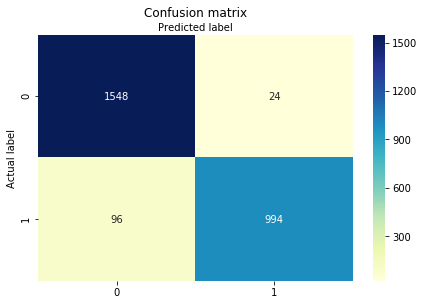

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [18]:
print("Accuracy:",metrics.accuracy_score(yvalid, y_pred))
print("Precision:",metrics.precision_score(yvalid, y_pred))
print("Recall:",metrics.recall_score(yvalid, y_pred))

Accuracy: 0.9549211119459053
Precision: 0.9764243614931237
Recall: 0.9119266055045872


Let's try to improve our model.
Instead of using TF-IDF, we can also use word counts as features. This can be done easily using CountVectorizer from scikit-learn.

In [19]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [21]:
# Fitting a simple Logistic Regression on Counts
ctv = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
#predictions = clf.predict_proba(xvalid_ctv)
y_pred=clf.predict(xvalid_ctv)
print("Accuracy:",metrics.accuracy_score(yvalid, y_pred))
print("Precision:",metrics.precision_score(yvalid, y_pred))
print("Recall:",metrics.recall_score(yvalid, y_pred))

Accuracy: 0.9429000751314801
Precision: 0.9263636363636364
Recall: 0.9348623853211009


our model ...

Next, let's try a very simple model which was quite famous in ancient times - Naive Bayes.
Let's see what happens when we use naive bayes on these two datasets:

In [22]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
y_pred=clf.predict(xvalid_tfv)
print("Accuracy:",metrics.accuracy_score(yvalid, y_pred))
print("Precision:",metrics.precision_score(yvalid, y_pred))
print("Recall:",metrics.recall_score(yvalid, y_pred))

Accuracy: 0.727648384673178
Precision: 0.997275204359673
Recall: 0.3357798165137615


Not good performance! But the logistic regression on counts is still better! What happens when we use this model on counts data instead?

In [23]:
# Fitting a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
y_pred=clf.predict(xvalid_ctv)
print("Accuracy:",metrics.accuracy_score(yvalid, y_pred))
print("Precision:",metrics.precision_score(yvalid, y_pred))
print("Recall:",metrics.recall_score(yvalid, y_pred))

Accuracy: 0.9120961682945155
Precision: 0.8948339483394834
Recall: 0.8899082568807339


Since SVMs take a lot of time, we will reduce the number of features from the TF-IDF using Singular Value Decomposition before applying SVM.
Also, note that before applying SVMs, we must standardize the data.

In [24]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

Now it's time to apply SVM. After running the following cell, feel free to go for a walk or talk.

In [25]:
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict(xvalid_svd_scl)

In [26]:
y_pred=clf.predict(xvalid_svd_scl)
print("Accuracy:",metrics.accuracy_score(yvalid, y_pred))
print("Precision:",metrics.precision_score(yvalid, y_pred))
print("Recall:",metrics.recall_score(yvalid, y_pred))

Accuracy: 0.9462809917355371
Precision: 0.943767572633552
Recall: 0.9238532110091743


Before moving further, lets apply the most popular algorithm on Kaggle: xgboost!

In [27]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict(xvalid_tfv.tocsc())



In [28]:
y_pred=clf.predict(xvalid_tfv.tocsc())
print("Accuracy:",metrics.accuracy_score(yvalid, y_pred))
print("Precision:",metrics.precision_score(yvalid, y_pred))
print("Recall:",metrics.recall_score(yvalid, y_pred))

Accuracy: 0.9556724267468069
Precision: 0.9584905660377359
Recall: 0.9321100917431193


In [29]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_ctv.tocsc(), ytrain)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-f5672e127e71>", line 4, in <module>
    clf.fit(xtrain_ctv.tocsc(), ytrain)
  File "/anaconda3/lib/python3.6/site-packages/xgboost/sklearn.py", line 547, in fit
    verbose_eval=verbose, xgb_model=None)
  File "/anaconda3/lib/python3.6/site-packages/xgboost/training.py", line 204, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/anaconda3/lib/python3.6/site-packages/xgboost/training.py", line 74, in _train_internal
    bst.update(dtrain, i, obj)
  File "/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 1021, in update
    dtrain.handle))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line

KeyboardInterrupt: 

In [ ]:
y_pred=clf.predict(xvalid_ctv.tocsc())
print("Accuracy:",metrics.accuracy_score(yvalid, y_pred))
print("Precision:",metrics.precision_score(yvalid, y_pred))
print("Recall:",metrics.recall_score(yvalid, y_pred))

In [ ]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, ytrain)

In [ ]:
y_pred=clf.predict(xvalid_svd)
print("Accuracy:",metrics.accuracy_score(yvalid, y_pred))
print("Precision:",metrics.precision_score(yvalid, y_pred))
print("Recall:",metrics.recall_score(yvalid, y_pred))

In [ ]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(nthread=10)
clf.fit(xtrain_svd, ytrain)

In [ ]:
y_pred=clf.predict(xvalid_svd)
print("Accuracy:",metrics.accuracy_score(yvalid, y_pred))
print("Precision:",metrics.precision_score(yvalid, y_pred))
print("Recall:",metrics.recall_score(yvalid, y_pred))